In [7]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

import matplotlib.pyplot as plt
from math import floor, ceil
from mimic_common import *
import os
import pandas as pd
from statistics import median

In [8]:
def read_df(group_name, group_1, group_2, suffix = None, ratio_bound = 5):
    """ 
    Absoluate bound for filtering out ratios
    """
    target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_equity.csv")
    if suffix is not None:
        target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_{suffix}_equity.csv")
    target_equity_df = pd.read_csv(target_equity_path, header=0, index_col=None)

    target_diff_percents = target_equity_df['target_diff_percent']
    target_diff_percents = [x for x in target_diff_percents if abs(x) < ratio_bound]

    return target_diff_percents

In [9]:
def plot_percents(group_name, group_1, group_2, diff_percent_1, proc_bias_1, diff_percent_2, proc_bias_2, ratio_bound = 5):
    """ 
    :param array diff_percent_1: error difference percent from group_1 to group_2
    :param array diff_percent_2: error difference percent from group_2 to group_1
    """

    bin_width = 0.1

    plt.subplot(1,2,1)
    plt.hist(diff_percent_1, bins=np.arange(-ratio_bound, \
                ratio_bound + bin_width, bin_width), density=True, alpha=0.5, label='transported target')
    plt.ylabel("density")
    plt.xlabel("ratio of difference predicted value and ground-truth value")
    plt.title(f"Source: {group_1}, \n Target: {group_2}, \n Procedure bias: {round(proc_bias_1, 2)}")
    plt.legend()

    plt.subplot(1,2,2)
    plt.hist(diff_percent_2, bins=np.arange(-ratio_bound, \
                ratio_bound + bin_width, bin_width), density=True, alpha=0.5, label='transported target')
    plt.ylabel("density")
    plt.xlabel("ratio of difference predicted value and ground-truth value")
    plt.title(f"Source: {group_2}, \n Target: {group_1}, \n Procedure bias: {round(proc_bias_2, 2)}")
    plt.legend()

    save_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}_and_{group_1}_fairness.pdf")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

In [10]:
def procedure_bias(target_diff_percents):
    """ 
    Quantifies the procedural bias between source error and target error
    :param list[float] source_diff_percents: (predicted value - ground truth value)/(ground truth value) for source 
    :param list[float] target_diff_percents: (transported predicted value - ground truth value)/(ground truth value) for target
    """
    
    # target_bias = ([True for i in target_diff_percents if i > 0].count(True))/len(target_diff_percents)
    # print(f"target bias is {target_bias}")
    # return target_bias
    return median(target_diff_percents)

In [11]:
def entire_proc(group_name, group_1, group_2, ratio_bound = 5):
    target_diff_percent_1 = read_df(group_name, group_1, group_2, ratio_bound = ratio_bound)
    target_diff_percent_2 = read_df(group_name, group_2, group_1, ratio_bound = ratio_bound)
    proc_bias_1 = procedure_bias(target_diff_percent_1)
    proc_bias_2 = procedure_bias(target_diff_percent_2)
    
    plot_percents(group_name, group_1, group_2, target_diff_percent_1, \
                  proc_bias_1, target_diff_percent_2, proc_bias_2, ratio_bound)
    return proc_bias_1, proc_bias_2

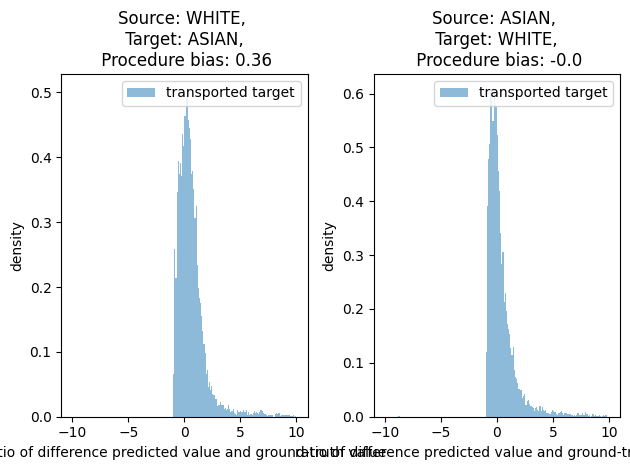

(0.3569893317277144, -0.0023597304125691)

In [12]:
# suffix = None
# group_name = 'marital_status'
# group_1 =  'MARRIED'
# group_2 = 'SINGLE'

# suffix = None
# group_name = 'insurance'
# group_1 = 'Private'   
# group_2 =  'Self_Pay'

# suffix = None
# group_name = 'gender'
# group_1 =  'F'
# group_2 = 'M'

suffix = None
group_name = 'ethnicity'
group_1 =  'WHITE'
# group_2 = 'HISPANIC_OR_LATINO'
group_2 = 'ASIAN'

ratio_bound = 10

entire_proc(group_name, group_1, group_2, ratio_bound=ratio_bound)